## Overview
This script contains the source code for generating figures used in ```NSCMasterThesis_XinyueYao.pdf``` to demonstrate results of a fully connected neural network. Users need to install necessary libraries and initialize the inference before creating figures.

In all functions:
* $\beta=0.0$ indicates an $L^p$ regularized model
* $\beta=1.0$ indicates a distance-constrained model


Relevant figures are:
* [Fig. 3.1](#wd)
* [Fig. 3.2](#acc)
* [Fig. A.1](#conn)

### Libraries required to run the script

In [1]:
import torch
import numpy as np
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
%matplotlib notebook
from matplotlib.ticker import (MultipleLocator)

from pathlib import Path

import utils
from train import NeuralNet as cm 

from scipy.optimize import curve_fit
from scipy import stats

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.patches as mpatches

### Load the json file and initialize the model setup

In [2]:
json_path = "./params.json"
params = utils.Params(json_path)
model = cm(params.input_size, params.hidden_size, params.output_size, params.n_spatial_dims, params.norm)
%matplotlib inline

In [3]:
'''Retrieve paths for checkpoints for all alphas in a sorted list'''
def load_alpha_path(path):
    alpha_path = list(glob(os.path.join(path, 'alpha_*')))
    file_paths = []
    for idx in range(len(alpha_path)):
        file_path = list(glob(os.path.join(str(alpha_path[idx]))))#, 'checkpoints'
        if len(file_path)!=1:
            raise ValueError(f'File path should receive one element: {file_path}')
        file_path = file_path[0]
        file_paths.append(file_path)
    return file_paths

In [4]:
'''Load weight and distance matrix as concatenated lists from the model checkpoint'''
def get_wd(model, ckpt_file):
    ckpt = utils.load_checkpoint(ckpt_file, model)
    weight = []
    dist = []
    for w, d in zip(model.layers_weight, model.distances):
        weight += [torch.flatten(w.data).numpy()]
        dist += [torch.flatten(d.data).numpy()]
    weight = np.concatenate(weight)
    dist = np.concatenate(dist)
    return model, weight, dist

In [6]:
def load_model_dict(f, key):
    plot_dict = dict()
    model = cm.NeuralNet(params.input_size, params.hidden_size, params.output_size, params.n_spatial_dims, params.norm)
    ckpt, ckpt_model = utils.load_checkpoint(f, model)
    dict_list = []
    key = str(key)
    for k, v in ckpt['state_dict'].items():
        if key in k:
            dict_list += [torch.flatten(v).numpy()]
    plot_dict = np.concatenate(dict_list)
    return plot_dict, ckpt

<a id="wd"></a>

### [Plot weight vs. distance distribution](#wd)
Function `plot_w_d` produces a weight vs. distance distribution for the first and the last epochs of the trained model for a specific seed (Relevant to Fig.3.1).

Users need to specify the values of alphas to be plotted.

Example:   
```plot_w_d(44, 1.0)```

Output: weight vs. distance distribution for the first and the last epochs in distance-constrained models ($\alpha \in \{0.0, 0.01, 0.05\}$, seed=44)

In [ ]:
def plot_w_d(seed, beta):
    # specify which alphas to be printed
    alphas = [0.0, 0.01,  0.05]
    
    n_c = 2
    n_r = len(alphas)
    fig, axs = plt.subplots(figsize=(8, 10), nrows=n_r, ncols=n_c)
    xlim = 5
    fig.align_ylabels()
    plt.setp(axs, xlim=(0,xlim))
    color = 'Blues'
    for i, a in zip(range(n_r), alphas):  
        init = list(glob(f'./trial{params.trial}/seed{seed}trained_model/alpha_{a}_beta_{beta}/checkpoints/initial.pth'))
        last = list(glob(f'./trial{params.trial}/seed{seed}trained_model/alpha_{a}_beta_{beta}/checkpoints/last.pth'))
        il = [*zip(init, last)]
        di = []
        wi = []
        dl = []
        wl = []
        for f1, f2 in il:
            for f, d_save, w_save in zip([f1, f2], [di, dl], [wi, wl]):
                weight, _ = load_model_dict(f, "weight")
                dist, _ = load_model_dict(f, "dist_")
                dist = dist[np.abs(weight) > 0.]
                weight = weight[np.abs(weight) > 0.]
                d_save.append(dist)
                w_save.append(weight)
            for ax, d, w, y_lim in zip([axs[i, 0], axs[i, 1]], [di, dl], [wi, wl], [max(max(np.abs(wi))), max(max(np.abs(wl)))]):
                hb = ax.hexbin(d, w, gridsize=30, cmap=color, norm=matplotlib.colors.LogNorm(), extent=[0, xlim,-y_lim, y_lim])
                ax.set_ylim(-y_lim, y_lim)
            axs[i,0].set_ylabel('weight distributions\nalpha='+f'{a}', multialignment='center', fontsize='large')#, fontweight='bold')
    
    cax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
    cb = fig.colorbar(hb, cax=cax)
#     c|b.set_label('log10(N)')
    axs[0,0].set_title('first epoch', fontsize='large')#, fontweight='bold')
    axs[0,1].set_title('last epoch', fontsize='large')#, fontweight='bold')
    axs[n_r-1,0].set_xlabel('internodal distance', fontsize='large')#, fontweight='bold')
    axs[n_r-1,1].set_xlabel('internodal distance', fontsize='large')#, fontweight='bold')
    
    fig.savefig(f'trial{params.trial}seed{seed}_{beta}_distance_weight.png', dpi=600, bbox_inches='tight')


<a id="acc"></a>

### [Accuracy of FCNN models with a Kolmogorov–Smirnov test for statistical analysis](#acc)
This plot produces the median of the model's accuracy from all experiments for each alpha value
(relevant to Fig. 3.2).

In [7]:
def ks_test(a, b, thres=0.05):
    d, p = stats.ks_2samp(a, b)
    return d, p, p < thres

D-stat is 0.4, p-value is 0.3128526760169558
D-stat is 0.8, p-value is 0.0012162112998959323
D-stat is 0.8, p-value is 0.0012162112998959323
D-stat is 0.6000000000000001, p-value is 0.031046781145641307
D-stat is 0.4, p-value is 0.3128526760169558
D-stat is 0.6, p-value is 0.031046781145641363
D-stat is 0.8, p-value is 0.0012162112998959323
D-stat is 0.9, p-value is 0.00017011925273829754


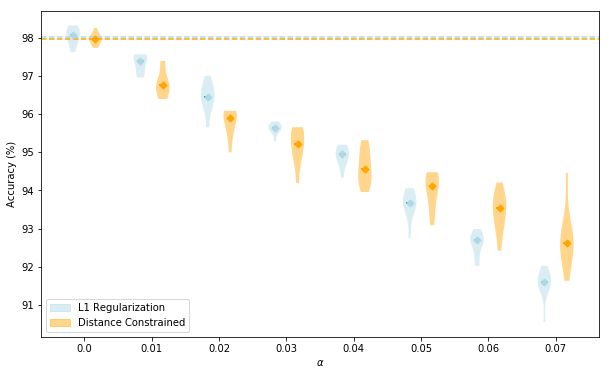

In [14]:
def plot_acc(trial=params.trial):
    betas = [0.0, 1.0]
    label = [f'L{params.norm} Regularization', 'Distance Constrained']
    colors = ['lightblue', 'orange']
    # specify alphas values to be checked
    alphas = np.arange(0.0, 0.08, 0.01)
    
    pos_a = [0.5+i*1.5 for i in range(len(alphas))]
    pos_b = [a+0.5 for a in pos_a]
    x_t = [a+0.5/2 for a in pos_a]
    position = [pos_a, pos_b]
    x_ticks = [str(a) for a in alphas]
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))
    labels = []
    l_acc = []
    d_acc = []
    for beta, color, l, pos, accs in zip(betas, colors, label, position, [l_acc, d_acc]):
        stdev = []
        for alpha in alphas:
            alpha = round(alpha, 5)
            files = list(glob(f'./trial{trial}/seed*trained_model/alpha_{alpha}_beta_{beta}/checkpoints/last.pth'))
            def avg(files):
                accs = []
                for f in files:
                    ckpt = torch.load(f, map_location='cpu')
                    acc = ckpt['accuracy']
                    accs.append(acc)
                return accs
            acc = avg(files)
            accs.append(acc)

        vp = ax.violinplot(accs, pos, points=20, widths=0.3, showmeans=False, showmedians=True, showextrema=False)
        ax.set_xticks(x_t)
        ax.set_xticklabels(x_ticks)
        for i, pc in enumerate(vp['bodies']):
            pc.set_facecolor(f'{color}')
            pc.set_alpha(0.45)
        add_label(vp, f'{l}')
        quartile1, medians, quartile3 = np.percentile(accs, [25, 50, 75], axis=1)
        ax.scatter(pos, medians, marker='D', color=color, s=25, zorder=3)
        
        base_acc = avg(list(glob(f'./trial{trial}/seed*trained_model/alpha_0.0_beta_{beta}/checkpoints/last.pth')))
        ax.axhline(np.mean(base_acc), linestyle='dashed', c=color)
    for a, b in zip(l_acc, d_acc):
        d, p, pv = ks_test(a, b)
        print(f'D-stat is {d}, p-value is {p}')
        
    ax.set(xlabel=r"$\alpha$", ylabel='Accuracy (%)')
    plt.legend(*zip(*labels), loc=0)
    plt.show()
    fig.savefig(f'trial_{trial}_acc.png', dpi=300, bbox_inches='tight')

<a id="conn"></a>

### [Plot the number of connections over distances](#conn)
Relevant to Fig. A.5

`plot_dist_conn_hres(5e-05, params)` produces the distribution of connections over internodal distance for $\alpha=5e-05$.    

`plot_dist_conn(5e-05, params)` produces the connectivity distribution of each range of distance for $\alpha=5e-05$.

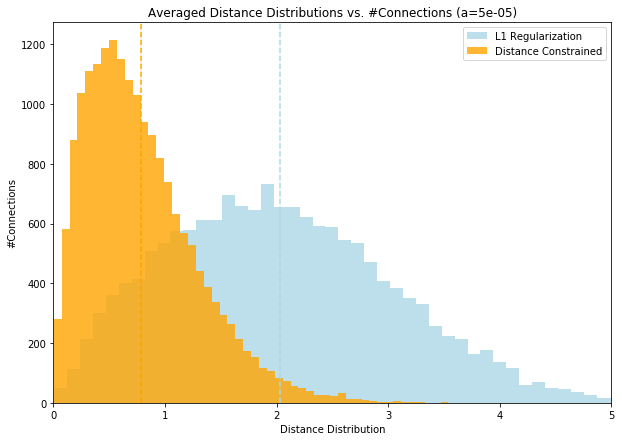

In [10]:
def plot_dist_conn_hres(alpha, hps, threshold=0.):
    files_seed = [np.sort(list(glob(f'./trial{params.trial}/seed*trained_model/alpha_{alpha}_beta_0.0/checkpoints/last.pth'))).tolist(),
                  np.sort(list(glob(f'./trial{params.trial}/seed*trained_model/alpha_{alpha}_beta_1.0/checkpoints/last.pth'))).tolist()]
    files = [*zip(files_seed[0], files_seed[1])]
    bins=50
    hist_f1 = []
    hist_f2 = []
    dist_f1 = []
    dist_f2 = []
    fig, ax = plt.subplots(figsize=(10, 7))
    for f1, f2 in files:
        for f, hist_save, dist_save in zip([f1, f2], [hist_f1, hist_f2], [dist_f1, dist_f2]):
            weight, _ = load_model_dict(f, "weight")
            dist, _ = load_model_dict(f, "dist_")
            h_d = dist[np.abs(weight) > threshold]
            h_d = h_d[h_d != 0.]
            dist_save.append(h_d.mean())
            hist_save += [*h_d]
    dist_f1 = np.average(dist_f1)
    dist_f2 = np.average(dist_f2)
    
    for hist, d_mean, beta, color in zip([hist_f1,hist_f2], [dist_f1, dist_f2], [f'L{params.norm} Regularization', 'Distance Constrained',], ['lightblue', 'orange']):
        ax.hist(hist, bins=bins, label=f'{beta}', color=color, alpha=0.8)
        ax.axvline(d_mean, linestyle='dashed', c=color)

    ax.set(title=f'Averaged Distance Distributions vs. #Connections (a={alpha})', 
           ylabel='#Connections', xlabel='Distance Distribution')
    ax.set_xlim([0, 5])
    ax.legend()
    plt.show()
    fig.savefig(f'trial{params.trial}_averaged_dc.png', dpi=400, bbox_inches='tight')


In [11]:
def plot_dist_conn(alpha, hps, threshold=0.):
    files_seed = [np.sort(list(glob(f'./trial{params.trial}/seed*trained_model/alpha_{alpha}_beta_0.0/checkpoints/last.pth'))).tolist(),
                  np.sort(list(glob(f'./trial{params.trial}/seed*trained_model/alpha_{alpha}_beta_1.0/checkpoints/last.pth'))).tolist()]
    files = [*zip(files_seed[0], files_seed[1])]
    
    width = 0.5
    bins = np.arange(0,3.,width)
    x_bar = (bins[1:] - bins[:-1]) / 2 + bins[:-1]
    x_ticks = ['D1', 'D2', 'D3', 'D4', 'D5']
    hist_f1 = []
    hist_f2 = []
    dist_f1 = []
    dist_f2 = []
    fig, ax = plt.subplots(figsize=(10, 7))
    for f1, f2 in files:
        for f, hist_save, dist_save in zip([f1, f2], [hist_f1, hist_f2], [dist_f1, dist_f2]):
            weight, _ = load_model_dict(f, "weight")
            dist, _ = load_model_dict(f, "dist_")
            h_d = dist[np.abs(weight) > threshold]
            h_d = h_d[h_d != 0.]
            dist_save.append(h_d.mean())
            
            # This outputs the histogram of the distance of nodes which have connections, 
            # and contains the number of samples in each bin; if density is set to be "True", the the result is a pdf
            counts, edges = np.histogram(h_d, bins=bins, density=False)
            
            hist_save.append(counts)
    dist_f1 = np.median(dist_f1)
    dist_f2 = np.median(dist_f2)
    hist_f1 = np.median(np.stack(hist_f1), axis=0)
    hist_f2 = np.median(np.stack(hist_f2), axis=0)
    labels = [f'L{params.norm} Regularization', 'Distance Constrained']
    for hist, d_mean, label, color in zip([hist_f1,hist_f2], [dist_f1, dist_f2], labels, ['lightblue', 'orange']):
        ax.bar(x_bar, hist, width=width, label=f'{label}', color=color, alpha=0.8)
        ax.axvline(d_mean, linestyle='dashed', c=color)

    ax.set(title=f'Levels of distance vs. #Connections (a={alpha})', 
           ylabel='#Connections', xlabel='Distance Distribution')
    ax.set_xlim([0, 2.5])
    ax.set_ylim([0, max(max(hist_f1), max(hist_f2))+0.1])
    ax.set_xticks(x_bar)
    ax.set_xticklabels(x_ticks)

    ax.legend()
    plt.show()
    fig.savefig(f'trial{params.trial}_alpha{alpha}_averaged_leveldis_conn.png', bbox_inches='tight')